In [1]:
import numpy
import numpy as np
import time
import datetime
import netCDF4
import matplotlib.pylab as plt
import os,sys,glob
sys.path.append(os.getcwd()+'/../adjust/rasotools/')
from utils import *
from multiprocessing import Pool
#import odb
from eccodes import *
from functools import partial
from collections import OrderedDict
import subprocess
import json
import gzip
# from retrieve_fb_jra55 import add_feedback
import copy
import pickle
import xarray as xr

import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt
matplotlib.rcParams.update({'font.size': 20})

plt.rcParams['lines.linewidth'] = 3

import warnings
warnings.filterwarnings('ignore')

sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua3 as eua
import trajectory as trj

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [3]:
# run to convert the sh files to gaussian gridded gribs

# command = ''
# command += 'module load intel-parallel-studio/composer.2020.4-intel-20.0.4; '
# command += 'module load intel-mkl/2020.4.304-intel-20.0.4; '
# command += 'module load openmpi/4.0.5-intel-20.0.4; '
# command += 'module load hdf5/1.12.0-intel-20.0.4; '
# command += 'module load netcdf-c/4.7.4-intel-20.0.4; '
# command += 'module load eccodes/2.21.0-intel-20.0.4; '
# command += 'cd PROGRAMS/; '
# command += 'ulimit -s unlimited; '
# command += 'export OMP_NUM_THREADS=69; '
# base_command = command
# for i in range(1,13,1):
#     for j in range(1,32,1):
#         try:
#             command = base_command + './transsh.exe /mnt/scratch/scratch/mayerj47/era5_sh/t/2020/T3DSH2020'+f"{i:02d}"+f"{j:02d}"+'0000.grib ./2020/T3DSH2020'+f"{i:02d}"+f"{j:02d}"+'0000.grib; '
#             command += './transsh.exe /scratch/das/mayerj47/era5_sh/lnspana/2020/LNSPANASH2020'+f"{i:02d}"+f"{j:02d}"+'0000.grib ./2020/LNSPANASH2020'+f"{i:02d}"+f"{j:02d}"+'0000.grib'
#             os.system(command)
#         except:
#             print(i, j)

In [4]:
# stat = '11035'
# statlist = glob.glob('/mnt/users/scratch/leo/scratch/converted_v7/*' + stat + '*_CEUAS_merged_v1.nc')
# df = eua.CDMDataset(filename = statlist[0]).to_dataframe(groups=['observations_table', 'era5fb'], variables=['latitude', 'longitude', 'observed_variable', 'observation_value', 'z_coordinate', 'date_time', 'fg_depar@body', 'an_depar@body', 'biascorr@body'])
# # 2020 only
# df = df[df.date_time.dt.year == 2020]
# # night only -> ~ 00:00
# df = df[np.isin(df.date_time.dt.hour,[23,0,1])]

In [5]:
# df['biascorr@body'].drop_duplicates()

In [ ]:
stat = '11035'
statlist = glob.glob('/mnt/users/scratch/leo/scratch/converted_v7/*' + stat + '*_CEUAS_merged_v1.nc')
df = eua.CDMDataset(filename = statlist[0]).to_dataframe(groups=['observations_table', 'era5fb'], variables=['latitude', 'longitude', 'observed_variable', 'observation_value', 'z_coordinate', 'date_time', 'fg_depar@body', 'an_depar@body'])
# 2020 only
df = df[df.date_time.dt.year == 2020]
# night only -> ~ 00:00
df = df[np.isin(df.date_time.dt.hour,[23,0,1])]

from scipy.signal import savgol_filter
# stdplevs = [92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]
stdplevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]
rmse_sum_shbase_sonde={}
rmse_sum_shbase_adjsonde={}
rmse_sum_shdisp_sonde={}
rmse_sum_shdisp_adjsonde={}
rms_sum_shbase={}
rms_sum_adjsonde={}
rms_sum_sonde={}
rms_sum_shdisp={}

for i in stdplevs:
    rmse_sum_shbase_sonde[i] = []
    rmse_sum_shbase_adjsonde[i] = []
    rmse_sum_shdisp_sonde[i] = []
    rmse_sum_shdisp_adjsonde[i] = []
    rms_sum_shbase[i] = []
    rms_sum_adjsonde[i] = []
    rms_sum_sonde[i] = []
    rms_sum_shdisp[i] = []

for day in df.date_time.drop_duplicates()[:100]:
    test = df[df.date_time == day]
    print(day)

    t = test[test.observed_variable == 85]
    t = t.rename(columns={'observation_value':'temperature'})
    t = t.drop(columns='observed_variable')

    u = test[test.observed_variable == 104]
    u = u.rename(columns={'observation_value':'u'})
    u = u.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

    v = test[test.observed_variable == 105]
    v = v.rename(columns={'observation_value':'v'})
    v = v.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

    input_data = pd.merge(t, u, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])
    input_data = pd.merge(input_data, v, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])

    input_data = input_data.dropna()
    input_data = input_data.reindex(index=input_data.index[::-1])
    phys_model = trj.trajectory(lat=t.latitude.iloc[0], lon=t.longitude.iloc[0], temperature=np.array(input_data.temperature), u=np.array(input_data.u), v=np.array(input_data.v), pressure=np.array(input_data.z_coordinate))
    input_data['z'] = np.array(trj.calc_height(np.array(input_data.temperature), np.array(input_data.z_coordinate), jump=False))
    input_data['calc_latd'] = np.array(phys_model[0])
    input_data['calc_lond'] = np.array(phys_model[1])
    input_data = input_data.reindex(index=input_data.index[::-1])
    input_data = input_data.reset_index()
    
    files = glob.glob('/mnt/scratch/scratch/leo/scratch/era5/gridded/era5fct.'+str(day.year)+str(day.month).zfill(2)+'*.130.nc')[0]
    ds_fc = xr.load_dataset(files)
    ds_fc_time = ds_fc.sel(time=day, method='nearest')
#     ds_fc_loc = ds_fc_time.interp(latitude=search_lat, longitude=search_lon, method='linear')
#     df_fc_loc = ds_fc_loc.to_dataframe()
    
#     display(input_data)
    t_list = []
    for i in np.array(ds_fc_time.level): #10,20,...,1000
        step = find_nearest(input_data.z_coordinate, i*100)
#         print('step - level: ', step)
        input_data_step = input_data[input_data.z_coordinate == step]
#         print('displacement: ', input_data_step.calc_latd)
        station_lat = input_data.latitude[0] + np.array(input_data_step.calc_latd)[0]
#         print(i, input_data.latitude[0], station_lat)
        station_lon = input_data.longitude[0] + np.array(input_data_step.calc_lond)[0]
#         print(i, input_data.longitude[0], station_lon)

        ds_now = ds_fc_time.interp(latitude=[station_lat], longitude=[station_lon], method="linear")
#         print('selected lat: ', float(ds_now.latitude))
        t = ds_now.t.sel(level = i)
        t_list.append(float(t))

    print('lat: ', input_data.latitude[0], 'lon: ', input_data.longitude[0])
    print(stat)
    print(day)
    p_ml = [  1000,   2000,   3000,   5000,   7000,  10000,  15000,  20000,  25000,  30000,  40000,  50000,  70000,  85000,  92500, 100000]
    base_t = np.array(ds_fc_time.interp(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="linear").t)
    for i in range(len(stdplevs)):
        if np.abs(stdplevs[i] - find_nearest(p_ml,stdplevs[i])) > 500:
            print(stdplevs[i] , find_nearest(p_ml,stdplevs[i]))
            rmse_sum_shbase_sonde[stdplevs[i]].append(np.nan)
            rmse_sum_shbase_adjsonde[stdplevs[i]].append(np.nan)
            rmse_sum_shdisp_sonde[stdplevs[i]].append(np.nan)
            rmse_sum_shdisp_adjsonde[stdplevs[i]].append(np.nan)
            rms_sum_shbase[stdplevs[i]].append(np.nan)
            rms_sum_adjsonde[stdplevs[i]].append(np.nan)
            rms_sum_sonde[stdplevs[i]].append(np.nan)
            rms_sum_shdisp[stdplevs[i]].append(np.nan)
        else:
            sq_t = np.squeeze(base_t)
            t_base = float(sq_t[p_ml == find_nearest(p_ml,stdplevs[i])])
            t_disp = float(np.array(t_list)[p_ml == find_nearest(p_ml,stdplevs[i])])
            input_data_step = input_data[input_data.z_coordinate == find_nearest(input_data.z_coordinate, stdplevs[i])]
            t_sonde = float(input_data_step.temperature)
#             t_adjsonde = float(input_data_step.temperature) - float(input_data_step['fg_depar@body']) - float(input_data_step['an_depar@body'])
            t_adjsonde = float(input_data_step.temperature) - float(input_data_step['an_depar@body'])

            rmse_sum_shbase_sonde[stdplevs[i]].append(t_base - t_sonde)
            rmse_sum_shbase_adjsonde[stdplevs[i]].append(t_base - t_adjsonde)
            rmse_sum_shdisp_sonde[stdplevs[i]].append(t_disp - t_sonde)
            rmse_sum_shdisp_adjsonde[stdplevs[i]].append(t_disp - t_adjsonde)
            rms_sum_shbase[stdplevs[i]].append(t_base)
            rms_sum_adjsonde[stdplevs[i]].append(t_adjsonde)
            rms_sum_sonde[stdplevs[i]].append(t_sonde)
            rms_sum_shdisp[stdplevs[i]].append(t_disp)
        
        
#     fig, ax1 = maplt.subplots(1, figsize=(16, 8))
#     ax1.plot(np.squeeze(base_t), np.array(p_ml), color = 'green', alpha = 0.6, label='base tempterature')
#     ax1.plot(np.array(t_list), np.array(p_ml), color = 'blue', alpha = 0.2,ls = '--', label='displaced temperature')
#     ax1.plot(np.array(input_data.temperature), np.array(input_data.z_coordinate), color = 'red', alpha = 0.2,ls = '--', label='temperature radio sonde')
# #     ax1.plot(np.array(input_data.temperature - input_data['an_depar@body'] ), np.array(input_data.z_coordinate), color = 'orange', alpha = 0.6, label='temperature radio sonde - an_depar')
#     ax1.set_ylabel('pressure (Pa)')
#     ax1.set_xlabel('temperature (K)')
#     ax1.tick_params(axis='y')
#     ax1.set_ylim(ax1.get_ylim()[::-1])
#     ax1.legend()
#     ax1.grid()
#     maplt.show()
#     maplt.close()

rmse_shbase_sonde=[]
rmse_shbase_adjsonde=[]
rmse_shdisp_sonde=[]
rmse_shdisp_adjsonde=[]

rms_shbase=[]
rms_adjsonde=[]
rms_sonde=[]
rms_shdisp=[]

for i in range(len(stdplevs)):
    rmse_shbase_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_sonde[stdplevs[i]])**2))))
    print('rmse_shbase_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_sonde[-1])
    rmse_shbase_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_adjsonde[stdplevs[i]])**2))))
    print('rmse_shbase_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_adjsonde[-1])
    rmse_shdisp_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_sonde[stdplevs[i]])**2))))
    print('rmse_shdisp_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_sonde[-1])
    rmse_shdisp_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_adjsonde[stdplevs[i]])**2))))
    print('rmse_shdisp_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_adjsonde[-1])
    
    rms_shbase.append(np.sqrt(np.nanmean((np.array(rms_sum_shbase[stdplevs[i]])**2))))
    print('rms_shbase - plev: ', stdplevs[i], ' RMS: ', rms_shbase[-1])
    rms_adjsonde.append(np.sqrt(np.nanmean((np.array(rms_sum_adjsonde[stdplevs[i]])**2))))
    print('rms_adjsonde - plev: ', stdplevs[i], ' RMS: ', rms_adjsonde[-1])
    rms_sonde.append(np.sqrt(np.nanmean((np.array(rms_sum_sonde[stdplevs[i]])**2))))
    print('rms_sonde - plev: ', stdplevs[i], ' RMS: ', rms_sonde[-1])
    rms_shdisp.append(np.sqrt(np.nanmean((np.array(rms_sum_shdisp[stdplevs[i]])**2))))
    print('rms_shdisp - plev: ', stdplevs[i], ' RMS: ', rms_shdisp[-1])

print('')

fig, ax1 = maplt.subplots(figsize = (15,10))
ax1.plot(np.array(rmse_shbase_sonde),stdplevs,color='orange', label='rmse_shbase_sonde')
ax1.plot(np.array(rmse_shdisp_sonde),stdplevs, color='red', label='rmse_shdisp_sonde')
ax1_4 = ax1.twiny()
ax1_4.plot(np.array(rms_shdisp),stdplevs,color='grey', label='rms_shdisp')
ax1_4.plot(np.array(rms_shbase),stdplevs,color='grey',alpha=0.3, label='rms_shbase')
ax1_4.legend(loc='lower left')
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_ylabel('pressure (Pa)')
ax1.set_xlabel('Temperature RMSE')
ax1.legend(loc='upper right')
ax1.grid()

maplt.title('LEVEL Temperature RMSE')
maplt.show()
maplt.close()

In [ ]:
stat = '11035'
statlist = glob.glob('/mnt/users/scratch/leo/scratch/converted_v7/*' + stat + '*_CEUAS_merged_v1.nc')
df = eua.CDMDataset(filename = statlist[0]).to_dataframe(groups=['observations_table', 'era5fb'], variables=['latitude', 'longitude', 'observed_variable', 'observation_value', 'z_coordinate', 'date_time', 'fg_depar@body', 'an_depar@body'])
# 2020 only
df = df[df.date_time.dt.year == 2020]
# night only -> ~ 00:00
df = df[np.isin(df.date_time.dt.hour,[23,0,1])]

from scipy.signal import savgol_filter
# stdplevs = [92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]
stdplevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]
rmse_sum_shbase_sonde={}
rmse_sum_shbase_adjsonde={}
rmse_sum_shdisp_sonde={}
rmse_sum_shdisp_adjsonde={}
rms_sum_shbase={}
rms_sum_adjsonde={}
rms_sum_sonde={}
rms_sum_shdisp={}

for i in stdplevs:
    rmse_sum_shbase_sonde[i] = []
    rmse_sum_shbase_adjsonde[i] = []
    rmse_sum_shdisp_sonde[i] = []
    rmse_sum_shdisp_adjsonde[i] = []
    rms_sum_shbase[i] = []
    rms_sum_adjsonde[i] = []
    rms_sum_sonde[i] = []
    rms_sum_shdisp[i] = []

for day in df.date_time.drop_duplicates()[:100]:
    test = df[df.date_time == day]
    print(day)

    t = test[test.observed_variable == 85]
    t = t.rename(columns={'observation_value':'temperature'})
    t = t.drop(columns='observed_variable')

    u = test[test.observed_variable == 104]
    u = u.rename(columns={'observation_value':'u'})
    u = u.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

    v = test[test.observed_variable == 105]
    v = v.rename(columns={'observation_value':'v'})
    v = v.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

    input_data = pd.merge(t, u, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])
    input_data = pd.merge(input_data, v, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])

    input_data = input_data.dropna()
    input_data = input_data.reindex(index=input_data.index[::-1])
    phys_model = trj.trajectory(lat=t.latitude.iloc[0], lon=t.longitude.iloc[0], temperature=np.array(input_data.temperature), u=np.array(input_data.u), v=np.array(input_data.v), pressure=np.array(input_data.z_coordinate))
    input_data['z'] = np.array(trj.calc_height(np.array(input_data.temperature), np.array(input_data.z_coordinate), jump=False))
    input_data['calc_latd'] = np.array(phys_model[0])
    input_data['calc_lond'] = np.array(phys_model[1])
    input_data = input_data.reindex(index=input_data.index[::-1])
    input_data = input_data.reset_index()
    
    files = glob.glob('/mnt/scratch/scratch/leo/scratch/era5/gridded/era5t.'+str(day.year)+str(day.month).zfill(2)+'*.130.nc')[0]
    ds_fc = xr.load_dataset(files)
    ds_fc_time = ds_fc.sel(time=day, method='nearest')
#     ds_fc_loc = ds_fc_time.interp(latitude=search_lat, longitude=search_lon, method='linear')
#     df_fc_loc = ds_fc_loc.to_dataframe()
    
#     display(input_data)
    t_list = []
    for i in np.array(ds_fc_time.level): #10,20,...,1000
        step = find_nearest(input_data.z_coordinate, i*100)
#         print('step - level: ', step)
        input_data_step = input_data[input_data.z_coordinate == step]
#         print('displacement: ', input_data_step.calc_latd)
        station_lat = input_data.latitude[0] + np.array(input_data_step.calc_latd)[0]
#         print(i, input_data.latitude[0], station_lat)
        station_lon = input_data.longitude[0] + np.array(input_data_step.calc_lond)[0]
#         print(i, input_data.longitude[0], station_lon)

        ds_now = ds_fc_time.interp(latitude=[station_lat], longitude=[station_lon], method="linear")
#         print('selected lat: ', float(ds_now.latitude))
        t = ds_now.t.sel(level = i)
        t_list.append(float(t))

    print('lat: ', input_data.latitude[0], 'lon: ', input_data.longitude[0])
    print(stat)
    print(day)
    p_ml = [  1000,   2000,   3000,   5000,   7000,  10000,  15000,  20000,  25000,  30000,  40000,  50000,  70000,  85000,  92500, 100000]
    base_t = np.array(ds_fc_time.interp(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="linear").t)
    for i in range(len(stdplevs)):
        if np.abs(stdplevs[i] - find_nearest(p_ml,stdplevs[i])) > 500:
            print(stdplevs[i] , find_nearest(p_ml,stdplevs[i]))
            rmse_sum_shbase_sonde[stdplevs[i]].append(np.nan)
            rmse_sum_shbase_adjsonde[stdplevs[i]].append(np.nan)
            rmse_sum_shdisp_sonde[stdplevs[i]].append(np.nan)
            rmse_sum_shdisp_adjsonde[stdplevs[i]].append(np.nan)
            rms_sum_shbase[stdplevs[i]].append(np.nan)
            rms_sum_adjsonde[stdplevs[i]].append(np.nan)
            rms_sum_sonde[stdplevs[i]].append(np.nan)
            rms_sum_shdisp[stdplevs[i]].append(np.nan)
        else:
            sq_t = np.squeeze(base_t)
            t_base = float(sq_t[p_ml == find_nearest(p_ml,stdplevs[i])])
            t_disp = float(np.array(t_list)[p_ml == find_nearest(p_ml,stdplevs[i])])
            input_data_step = input_data[input_data.z_coordinate == find_nearest(input_data.z_coordinate, stdplevs[i])]
            t_sonde = float(input_data_step.temperature)
#             t_adjsonde = float(input_data_step.temperature) - float(input_data_step['fg_depar@body']) - float(input_data_step['an_depar@body'])
            t_adjsonde = float(input_data_step.temperature) - float(input_data_step['an_depar@body'])

            rmse_sum_shbase_sonde[stdplevs[i]].append(t_base - t_sonde)
            rmse_sum_shbase_adjsonde[stdplevs[i]].append(t_base - t_adjsonde)
            rmse_sum_shdisp_sonde[stdplevs[i]].append(t_disp - t_sonde)
            rmse_sum_shdisp_adjsonde[stdplevs[i]].append(t_disp - t_adjsonde)
            rms_sum_shbase[stdplevs[i]].append(t_base)
            rms_sum_adjsonde[stdplevs[i]].append(t_adjsonde)
            rms_sum_sonde[stdplevs[i]].append(t_sonde)
            rms_sum_shdisp[stdplevs[i]].append(t_disp)
        
        
#     fig, ax1 = maplt.subplots(1, figsize=(16, 8))
#     ax1.plot(np.squeeze(base_t), np.array(p_ml), color = 'green', alpha = 0.6, label='base tempterature')
#     ax1.plot(np.array(t_list), np.array(p_ml), color = 'blue', alpha = 0.2,ls = '--', label='displaced temperature')
#     ax1.plot(np.array(input_data.temperature), np.array(input_data.z_coordinate), color = 'red', alpha = 0.2,ls = '--', label='temperature radio sonde')
# #     ax1.plot(np.array(input_data.temperature - input_data['an_depar@body'] ), np.array(input_data.z_coordinate), color = 'orange', alpha = 0.6, label='temperature radio sonde - an_depar')
#     ax1.set_ylabel('pressure (Pa)')
#     ax1.set_xlabel('temperature (K)')
#     ax1.tick_params(axis='y')
#     ax1.set_ylim(ax1.get_ylim()[::-1])
#     ax1.legend()
#     ax1.grid()
#     maplt.show()
#     maplt.close()

rmse_shbase_sonde=[]
rmse_shbase_adjsonde=[]
rmse_shdisp_sonde=[]
rmse_shdisp_adjsonde=[]

rms_shbase=[]
rms_adjsonde=[]
rms_sonde=[]
rms_shdisp=[]

for i in range(len(stdplevs)):
    rmse_shbase_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_sonde[stdplevs[i]])**2))))
    print('rmse_shbase_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_sonde[-1])
    rmse_shbase_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_adjsonde[stdplevs[i]])**2))))
    print('rmse_shbase_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_adjsonde[-1])
    rmse_shdisp_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_sonde[stdplevs[i]])**2))))
    print('rmse_shdisp_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_sonde[-1])
    rmse_shdisp_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_adjsonde[stdplevs[i]])**2))))
    print('rmse_shdisp_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_adjsonde[-1])
    
    rms_shbase.append(np.sqrt(np.nanmean((np.array(rms_sum_shbase[stdplevs[i]])**2))))
    print('rms_shbase - plev: ', stdplevs[i], ' RMS: ', rms_shbase[-1])
    rms_adjsonde.append(np.sqrt(np.nanmean((np.array(rms_sum_adjsonde[stdplevs[i]])**2))))
    print('rms_adjsonde - plev: ', stdplevs[i], ' RMS: ', rms_adjsonde[-1])
    rms_sonde.append(np.sqrt(np.nanmean((np.array(rms_sum_sonde[stdplevs[i]])**2))))
    print('rms_sonde - plev: ', stdplevs[i], ' RMS: ', rms_sonde[-1])
    rms_shdisp.append(np.sqrt(np.nanmean((np.array(rms_sum_shdisp[stdplevs[i]])**2))))
    print('rms_shdisp - plev: ', stdplevs[i], ' RMS: ', rms_shdisp[-1])

print('')

fig, ax1 = maplt.subplots(figsize = (15,10))
ax1.plot(np.array(rmse_shbase_sonde),stdplevs,color='orange', label='rmse_shbase_sonde')
ax1.plot(np.array(rmse_shdisp_sonde),stdplevs, color='red', label='rmse_shdisp_sonde')
ax1_4 = ax1.twiny()
ax1_4.plot(np.array(rms_shdisp),stdplevs,color='grey', label='rms_shdisp')
ax1_4.plot(np.array(rms_shbase),stdplevs,color='grey',alpha=0.3, label='rms_shbase')
ax1_4.legend(loc='lower left')
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_ylabel('pressure (Pa)')
ax1.set_xlabel('Temperature RMSE')
ax1.legend(loc='upper right')
ax1.grid()

maplt.title('LEVEL Temperature RMSE')
maplt.show()
maplt.close()

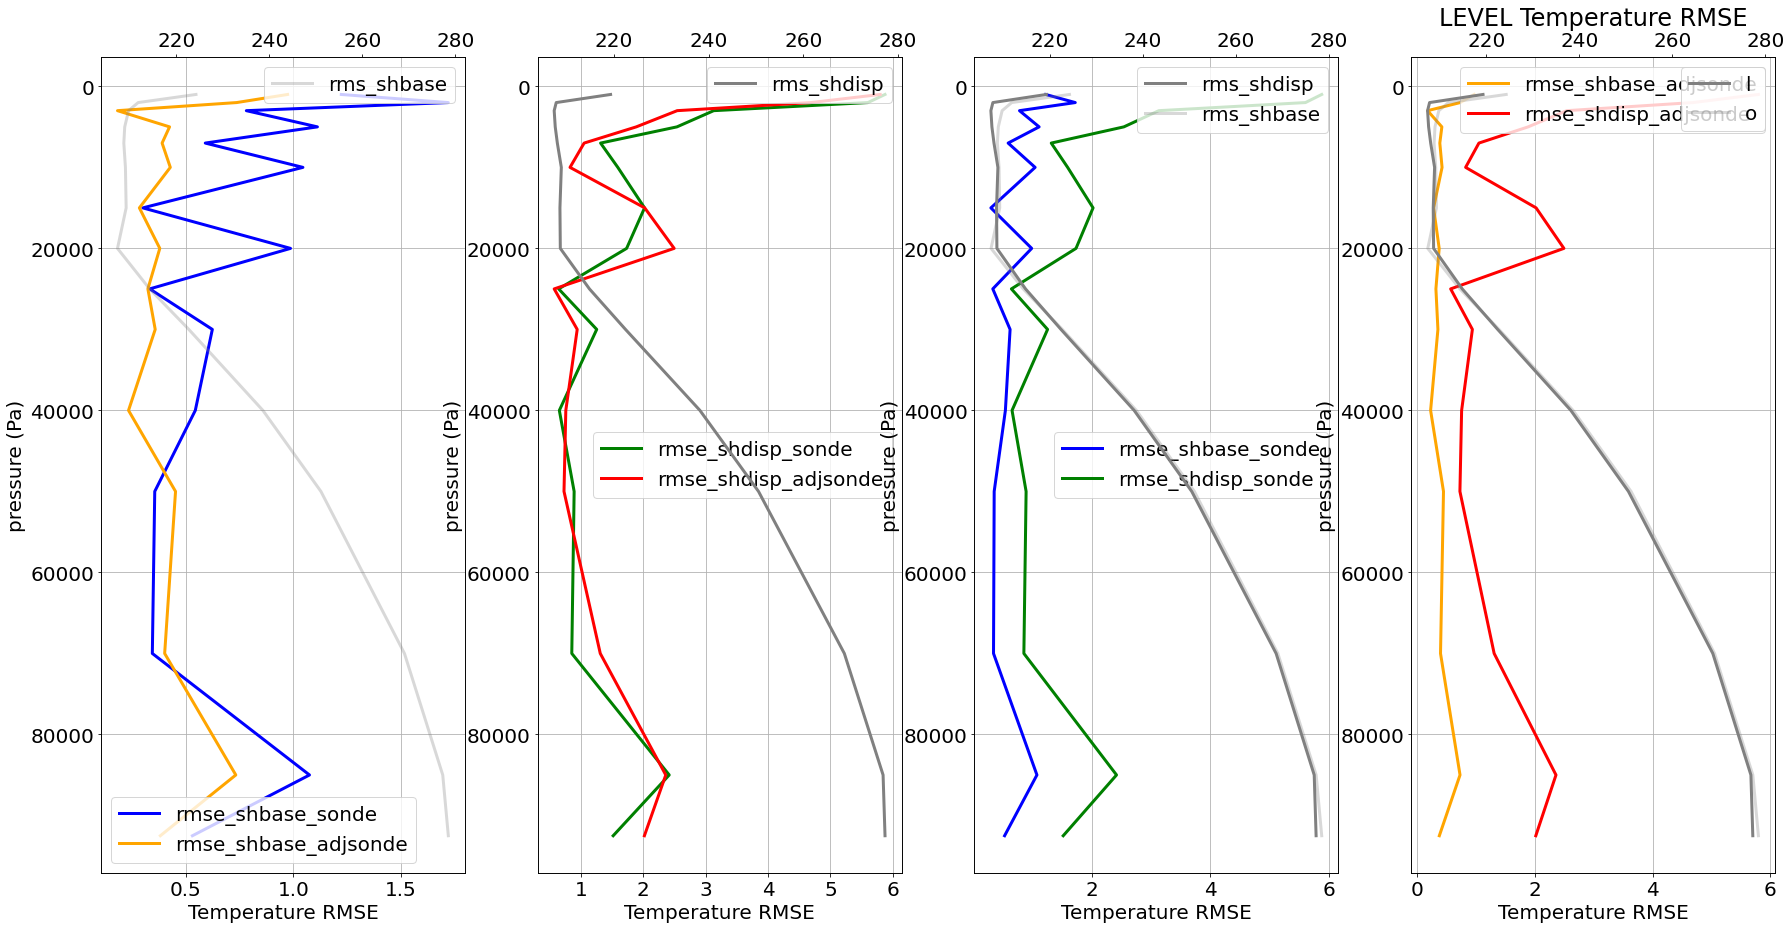

In [48]:
fig, ax1 = maplt.subplots(1,4,figsize = (30,15))

ax1[0].plot(np.array(rmse_shbase_sonde),stdplevs,color = 'blue', label='rmse_shbase_sonde')
ax1[0].plot(np.array(rmse_shbase_adjsonde),stdplevs,color='orange', label='rmse_shbase_adjsonde')
# ax1[0].plot(np.array(rmse_shdisp_sonde),stdplevs, label='rmse_shdisp_sonde')
# ax1[0].plot(np.array(rmse_shdisp_adjsonde),stdplevs, label='rmse_shdisp_adjsonde')
ax1_1 = ax1[0].twiny()
ax1_1.plot(np.array(rms_shbase),stdplevs,color='grey',alpha=0.3, label='rms_shbase')
ax1_1.legend()
ax1[0].set_ylim(ax1[0].get_ylim()[::-1])
ax1[0].set_ylabel('pressure (Pa)')
ax1[0].set_xlabel('Temperature RMSE')
ax1[0].legend()
ax1[0].grid()

# ax1[1].plot(np.array(rmse_shbase_sonde),stdplevs, label='rmse_shbase_sonde')
# ax1[1].plot(np.array(rmse_shbase_adjsonde),stdplevs, label='rmse_shbase_adjsonde')
ax1[1].plot(np.array(rmse_shdisp_sonde),stdplevs, color='green', label='rmse_shdisp_sonde')
ax1[1].plot(np.array(rmse_shdisp_adjsonde),stdplevs, color='red', label='rmse_shdisp_adjsonde')
ax1_2 = ax1[1].twiny()
ax1_2.plot(np.array(rms_shdisp),stdplevs,color='grey', label='rms_shdisp')
ax1_2.legend()
ax1[1].set_ylim(ax1[1].get_ylim()[::-1])
ax1[1].set_ylabel('pressure (Pa)')
ax1[1].set_xlabel('Temperature RMSE')
ax1[1].legend()
ax1[1].grid()

ax1[2].plot(np.array(rmse_shbase_sonde),stdplevs,color = 'blue', label='rmse_shbase_sonde')
ax1[2].plot(np.array(rmse_shdisp_sonde),stdplevs, color='green', label='rmse_shdisp_sonde')
ax1_3 = ax1[2].twiny()
ax1_3.plot(np.array(rms_shdisp),stdplevs,color='grey', label='rms_shdisp')
ax1_3.plot(np.array(rms_shbase),stdplevs,color='grey',alpha=0.3, label='rms_shbase')
ax1_3.legend()
ax1[2].set_ylim(ax1[2].get_ylim()[::-1])
ax1[2].set_ylabel('pressure (Pa)')
ax1[2].set_xlabel('Temperature RMSE')
ax1[2].legend()
ax1[2].grid()

ax1[3].plot(np.array(rmse_shbase_adjsonde),stdplevs,color='orange', label='rmse_shbase_adjsonde')
ax1[3].plot(np.array(rmse_shdisp_adjsonde),stdplevs, color='red', label='rmse_shdisp_adjsonde')
ax1_4 = ax1[3].twiny()
ax1_4.plot(np.array(rms_shdisp),stdplevs,color='grey', label='rms_shdisp')
ax1_4.plot(np.array(rms_shbase),stdplevs,color='grey',alpha=0.3, label='rms_shbase')
ax1_4.legend('lower left')
ax1[3].set_ylim(ax1[3].get_ylim()[::-1])
ax1[3].set_ylabel('pressure (Pa)')
ax1[3].set_xlabel('Temperature RMSE')
ax1[3].legend(loc='upper right')
ax1[3].grid()

maplt.title('LEVEL Temperature RMSE')
maplt.show()
maplt.close()

In [16]:
stat = '11035'
statlist = glob.glob('/mnt/users/scratch/leo/scratch/converted_v7/*' + stat + '*_CEUAS_merged_v1.nc')
df = eua.CDMDataset(filename = statlist[0]).to_dataframe(groups=['observations_table', 'era5fb'], variables=['latitude', 'longitude', 'observed_variable', 'observation_value', 'z_coordinate', 'date_time', 'fg_depar@body', 'an_depar@body'])
# 2020 only
df = df[df.date_time.dt.year == 2020]
# night only -> ~ 00:00
df = df[np.isin(df.date_time.dt.hour,[23,0,1])]

from scipy.signal import savgol_filter
stdplevs = [92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]
rmse_sum_shbase_sonde={}
rmse_sum_shbase_adjsonde={}
rmse_sum_shdisp_sonde={}
rmse_sum_shdisp_adjsonde={}
rms_sum_shbase={}
rms_sum_adjsonde={}
rms_sum_sonde={}
rms_sum_shdisp={}

for i in stdplevs:
    rmse_sum_shbase_sonde[i] = []
    rmse_sum_shbase_adjsonde[i] = []
    rmse_sum_shdisp_sonde[i] = []
    rmse_sum_shdisp_adjsonde[i] = []
    rms_sum_shbase[i] = []
    rms_sum_adjsonde[i] = []
    rms_sum_sonde[i] = []
    rms_sum_shdisp[i] = []

for day in df.date_time.drop_duplicates()[:30]:
    test = df[df.date_time == day]
    print(day)

    t = test[test.observed_variable == 85]
    t = t.rename(columns={'observation_value':'temperature'})
    t = t.drop(columns='observed_variable')

    u = test[test.observed_variable == 104]
    u = u.rename(columns={'observation_value':'u'})
    u = u.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

    v = test[test.observed_variable == 105]
    v = v.rename(columns={'observation_value':'v'})
    v = v.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

    input_data = pd.merge(t, u, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])
    input_data = pd.merge(input_data, v, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])

    input_data = input_data.dropna()
    phys_model = trj.trajectory(lat=t.latitude.iloc[0], lon=t.longitude.iloc[0], temperature=np.array(input_data.temperature), u=np.array(input_data.u), v=np.array(input_data.v), pressure=np.array(input_data.z_coordinate))


    input_data = input_data.reindex(index=input_data.index[::-1])
    input_data['z'] = np.array(trj.calc_height(np.array(input_data.temperature), np.array(input_data.z_coordinate), jump=False))
    input_data['calc_latd'] = np.array(phys_model[0])
    input_data['calc_lond'] = np.array(phys_model[1])

    test1 = [0] + list(input_data.calc_lond[:-1])
    test2 = [0] + list(input_data.calc_latd[:-1])
    input_data['prev_calc_lond']= test1
    input_data['prev_calc_latd']= test2

    input_data['lat_diff'] = np.array(input_data.calc_latd)- np.array(input_data.prev_calc_latd)
    input_data['lon_diff'] = np.array(input_data.calc_lond)- np.array(input_data.prev_calc_lond)


    input_data = input_data.dropna()


    with open('model_dt_no_dec_reduced_prev_new.p', "rb") as input_file:
        model = pickle.load(input_file)

    out = model.predict(input_data[['temperature', 'z_coordinate', 'u', 'v', 'z','latitude', 'longitude' , 'calc_latd', 'calc_lond', 'prev_calc_lond', 'prev_calc_latd', 'lon_diff', 'lat_diff']])

    ml_latd, ml_lond = out.transpose()
    filterlen = int(len(ml_latd)//2)
    if not (filterlen & 0x1):
        filterlen += 1
    input_data['ml_latd'] = np.array(savgol_filter(ml_latd, filterlen, 3))
    input_data['ml_lond'] = np.array(savgol_filter(ml_lond, filterlen, 3))

    input_data = input_data.reset_index()

    if day.hour == 23:
        day = day + pd.Timedelta(days=1)
        day = day.replace(hour = 0)
    ds = xr.load_dataset("./PROGRAMS/"+str(day.year)+"/T3DSH"+str(day.year)+f"{day.month:02d}"+f"{day.day:02d}"+f"{day.hour:02d}"+"00.grib")
    ds_lnsp = xr.load_dataset("./PROGRAMS/"+str(day.year)+"/LNSPANASH"+str(day.year)+f"{day.month:02d}"+f"{day.day:02d}"+f"{day.hour:02d}"+"00.grib")



    igrib = '/scratch/das/mayerj47/era5_sh/lnspana/'+str(day.year)+'/LNSPANASH'+str(day.year)+f"{day.month:02d}"+f"{day.day:02d}"+f"{day.hour:02d}"+'00.grib'
    f = open(igrib)
#     print(f)
    msgid = codes_new_from_file(f, product_kind=CODES_PRODUCT_GRIB)
#     print(msgid)
    pv = codes_get_array(msgid,'pv')

    lnsp = float(ds_lnsp.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").lnsp)
    sp = np.exp(lnsp)

    pv = np.array(pv)
    a = pv[:int(len(pv)/2)]
    b = pv[int(len(pv)/2):]

    p_half = a + b * sp
    p_ml = []
    for i in range(len(p_half)-1):
        p_ml.append((p_half[i] + p_half[i+1])/2.)
    p_ml = np.array(p_ml)
    base_t = ds.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").t

    t_list = []
    for i in range(len(p_ml)):
        step = find_nearest(input_data.z_coordinate, p_ml[i])
        input_data_step = input_data[input_data.z_coordinate == step]
        station_lat = float(input_data.latitude[0]) + np.array(input_data_step.ml_latd)[0]
    #     print(station_lat)
        station_lon = float(input_data.longitude[0]) + np.array(input_data_step.ml_lond)[0]

        ds_now = ds.sel(latitude=[station_lat], longitude=[station_lon], method="nearest")
    #     print('selected lat: ', float(ds_now.latitude))
        t = ds_now.t
        t_list.append(np.array(t)[i][0][0])
    print('lat: ', input_data.latitude[0], 'lon: ', input_data.longitude[0])
    print(stat)
    print(day)
    for i in range(len(stdplevs)):
        if np.abs(stdplevs[i] - find_nearest(p_ml,stdplevs[i])) > 1000:
            print(stdplevs[i] , find_nearest(p_ml,stdplevs[i]))
            rmse_sum_shbase_sonde[stdplevs[i]].append(np.nan)
            rmse_sum_shbase_adjsonde[stdplevs[i]].append(np.nan)
            rmse_sum_shdisp_sonde[stdplevs[i]].append(np.nan)
            rmse_sum_shdisp_adjsonde[stdplevs[i]].append(np.nan)
            rms_sum_shbase[stdplevs[i]].append(np.nan)
            rms_sum_adjsonde[stdplevs[i]].append(np.nan)
            rms_sum_sonde[stdplevs[i]].append(np.nan)
            rms_sum_shdisp[stdplevs[i]].append(np.nan)
        else:
            sq_t = np.squeeze(t)
            t_base = float(sq_t[p_ml == find_nearest(p_ml,stdplevs[i])])
            t_disp = float(np.array(t_list)[p_ml == find_nearest(p_ml,stdplevs[i])])
            input_data_step = input_data[input_data.z_coordinate == find_nearest(input_data.z_coordinate, stdplevs[i])]
            t_sonde = float(input_data_step.temperature)
#             t_adjsonde = float(input_data_step.temperature) - float(input_data_step['fg_depar@body']) - float(input_data_step['an_depar@body'])
            t_adjsonde = float(input_data_step.temperature) - float(input_data_step['an_depar@body'])

            rmse_sum_shbase_sonde[stdplevs[i]].append(t_base - t_sonde)
            rmse_sum_shbase_adjsonde[stdplevs[i]].append(t_base - t_adjsonde)
            rmse_sum_shdisp_sonde[stdplevs[i]].append(t_disp - t_sonde)
            rmse_sum_shdisp_adjsonde[stdplevs[i]].append(t_disp - t_adjsonde)
            rms_sum_shbase[stdplevs[i]].append(t_base)
            rms_sum_adjsonde[stdplevs[i]].append(t_adjsonde)
            rms_sum_sonde[stdplevs[i]].append(t_sonde)
            rms_sum_shdisp[stdplevs[i]].append(t_disp)
        
        
    fig, ax1 = maplt.subplots(1, figsize=(16, 8))
    ax1.plot(np.squeeze(t), np.array(p_ml), color = 'green', alpha = 0.6, label='base tempterature')
    ax1.plot(np.array(t_list), np.array(p_ml), color = 'blue', alpha = 0.2,ls = '--', label='displaced temperature')
    ax1.plot(np.array(input_data.temperature), np.array(input_data.z_coordinate), color = 'red', alpha = 0.2,ls = '--', label='temperature radio sonde')
    ax1.plot(np.array(input_data.temperature - input_data['an_depar@body'] ), np.array(input_data.z_coordinate), color = 'orange', alpha = 0.6, label='temperature radio sonde - an_depar')
    ax1.set_ylabel('pressure (Pa)')
    ax1.set_xlabel('temperature (K)')
    ax1.tick_params(axis='y')
    ax1.set_ylim(ax1.get_ylim()[::-1])
    ax1.legend()
    ax1.grid()
    maplt.show()
    maplt.close()

rmse_shbase_sonde=[]
rmse_shbase_adjsonde=[]
rmse_shdisp_sonde=[]
rmse_shdisp_adjsonde=[]

rms_shbase=[]
rms_adjsonde=[]
rms_sonde=[]
rms_shdisp=[]

for i in range(len(stdplevs)):
    rmse_shbase_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_sonde[stdplevs[i]])**2))))
    print('rmse_shbase_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_sonde[-1])
    rmse_shbase_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_adjsonde[stdplevs[i]])**2))))
    print('rmse_shbase_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_adjsonde[-1])
    rmse_shdisp_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_sonde[stdplevs[i]])**2))))
    print('rmse_shdisp_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_sonde[-1])
    rmse_shdisp_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_adjsonde[stdplevs[i]])**2))))
    print('rmse_shdisp_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_adjsonde[-1])
    
    rms_shbase.append(np.sqrt(np.nanmean((np.array(rms_sum_shbase[stdplevs[i]])**2))))
    print('rms_shbase - plev: ', stdplevs[i], ' RMS: ', rms_shbase[-1])
    rms_adjsonde.append(np.sqrt(np.nanmean((np.array(rms_sum_adjsonde[stdplevs[i]])**2))))
    print('rms_adjsonde - plev: ', stdplevs[i], ' RMS: ', rms_adjsonde[-1])
    rms_sonde.append(np.sqrt(np.nanmean((np.array(rms_sum_sonde[stdplevs[i]])**2))))
    print('rms_sonde - plev: ', stdplevs[i], ' RMS: ', rms_sonde[-1])
    rms_shdisp.append(np.sqrt(np.nanmean((np.array(rms_sum_shdisp[stdplevs[i]])**2))))
    print('rms_shdisp - plev: ', stdplevs[i], ' RMS: ', rms_shdisp[-1])

print('')

fig, ax1 = maplt.subplots(figsize = (15,10))
ax1.plot(np.array(rmse_shbase_adjsonde),stdplevs,color='orange', label='rmse_shbase_adjsonde')
ax1.plot(np.array(rmse_shdisp_adjsonde),stdplevs, color='red', label='rmse_shdisp_adjsonde')
ax1_4 = ax1.twiny()
ax1_4.plot(np.array(rms_shdisp),stdplevs,color='grey', label='rms_shdisp')
ax1_4.plot(np.array(rms_shbase),stdplevs,color='grey',alpha=0.3, label='rms_shbase')
ax1_4.legend(loc='lower left')
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_ylabel('pressure (Pa)')
ax1.set_xlabel('Temperature RMSE')
ax1.legend(loc='upper right')
ax1.grid()

maplt.title('LEVEL Temperature RMSE')
maplt.show()
maplt.close()

2020-01-01 23:30:34


FileNotFoundError: [Errno 2] No such file or directory: '/scratch/das/mayerj47/era5_sh/lnspana/2020/LNSPANASH202001020000.grib'

In [ ]:
p_ml

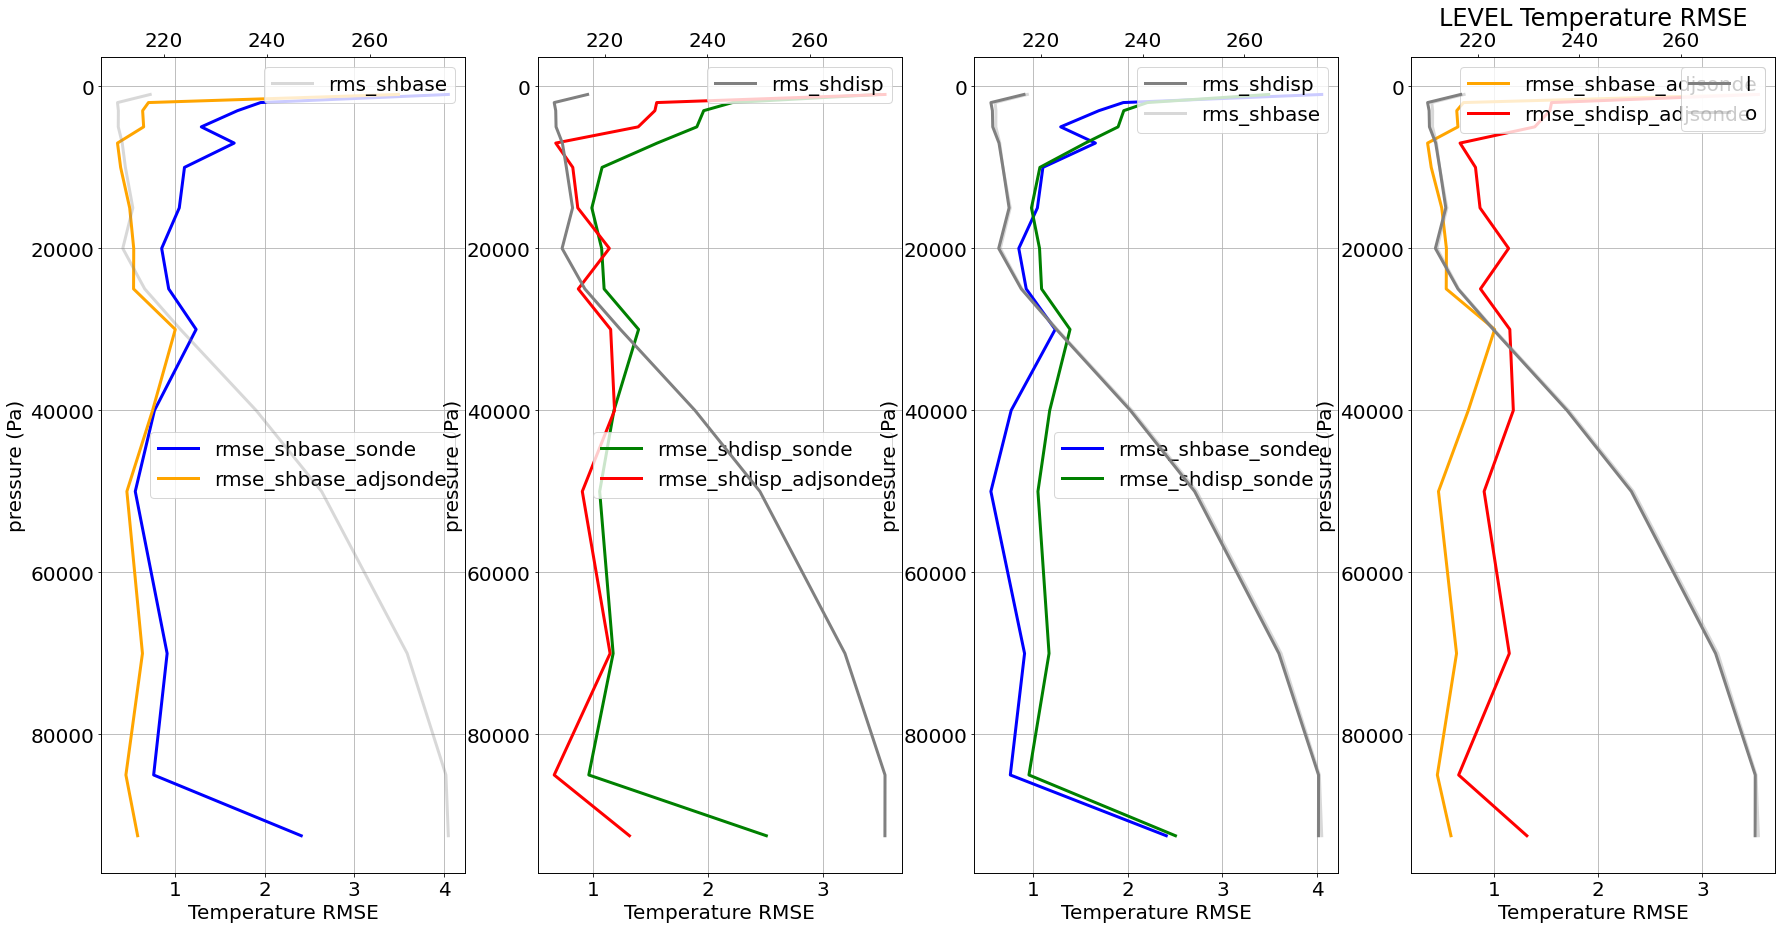

In [30]:
fig, ax1 = maplt.subplots(1,4,figsize = (30,15))

ax1[0].plot(np.array(rmse_shbase_sonde),stdplevs,color = 'blue', label='rmse_shbase_sonde')
ax1[0].plot(np.array(rmse_shbase_adjsonde),stdplevs,color='orange', label='rmse_shbase_adjsonde')
# ax1[0].plot(np.array(rmse_shdisp_sonde),stdplevs, label='rmse_shdisp_sonde')
# ax1[0].plot(np.array(rmse_shdisp_adjsonde),stdplevs, label='rmse_shdisp_adjsonde')
ax1_1 = ax1[0].twiny()
ax1_1.plot(np.array(rms_shbase),stdplevs,color='grey',alpha=0.3, label='rms_shbase')
ax1_1.legend()
ax1[0].set_ylim(ax1[0].get_ylim()[::-1])
ax1[0].set_ylabel('pressure (Pa)')
ax1[0].set_xlabel('Temperature RMSE')
ax1[0].legend()
ax1[0].grid()

# ax1[1].plot(np.array(rmse_shbase_sonde),stdplevs, label='rmse_shbase_sonde')
# ax1[1].plot(np.array(rmse_shbase_adjsonde),stdplevs, label='rmse_shbase_adjsonde')
ax1[1].plot(np.array(rmse_shdisp_sonde),stdplevs, color='green', label='rmse_shdisp_sonde')
ax1[1].plot(np.array(rmse_shdisp_adjsonde),stdplevs, color='red', label='rmse_shdisp_adjsonde')
ax1_2 = ax1[1].twiny()
ax1_2.plot(np.array(rms_shdisp),stdplevs,color='grey', label='rms_shdisp')
ax1_2.legend()
ax1[1].set_ylim(ax1[1].get_ylim()[::-1])
ax1[1].set_ylabel('pressure (Pa)')
ax1[1].set_xlabel('Temperature RMSE')
ax1[1].legend()
ax1[1].grid()

ax1[2].plot(np.array(rmse_shbase_sonde),stdplevs,color = 'blue', label='rmse_shbase_sonde')
ax1[2].plot(np.array(rmse_shdisp_sonde),stdplevs, color='green', label='rmse_shdisp_sonde')
ax1_3 = ax1[2].twiny()
ax1_3.plot(np.array(rms_shdisp),stdplevs,color='grey', label='rms_shdisp')
ax1_3.plot(np.array(rms_shbase),stdplevs,color='grey',alpha=0.3, label='rms_shbase')
ax1_3.legend()
ax1[2].set_ylim(ax1[2].get_ylim()[::-1])
ax1[2].set_ylabel('pressure (Pa)')
ax1[2].set_xlabel('Temperature RMSE')
ax1[2].legend()
ax1[2].grid()

ax1[3].plot(np.array(rmse_shbase_adjsonde),stdplevs,color='orange', label='rmse_shbase_adjsonde')
ax1[3].plot(np.array(rmse_shdisp_adjsonde),stdplevs, color='red', label='rmse_shdisp_adjsonde')
ax1_4 = ax1[3].twiny()
ax1_4.plot(np.array(rms_shdisp),stdplevs,color='grey', label='rms_shdisp')
ax1_4.plot(np.array(rms_shbase),stdplevs,color='grey',alpha=0.3, label='rms_shbase')
ax1_4.legend('lower left')
ax1[3].set_ylim(ax1[3].get_ylim()[::-1])
ax1[3].set_ylabel('pressure (Pa)')
ax1[3].set_xlabel('Temperature RMSE')
ax1[3].legend(loc='upper right')
ax1[3].grid()

maplt.title('LEVEL Temperature RMSE')
maplt.show()
maplt.close()